In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import *

%matplotlib notebook
pd.options.display.float_format = '{:.2f}'.format

In [2]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [3]:
tweets_df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

# Exploratory Data Analysis

In [4]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 729129 entries, 1331706590525874184 to 1000259808442961920
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   userid                    729129 non-null  string        
 1   user_display_name         729129 non-null  string        
 2   user_screen_name          729129 non-null  string        
 3   user_reported_location    545336 non-null  string        
 4   user_profile_description  684476 non-null  string        
 5   user_profile_url          448380 non-null  string        
 6   follower_count            729129 non-null  int64         
 7   following_count           729129 non-null  int64         
 8   account_creation_date     729129 non-null  datetime64[ns]
 9   account_language          729129 non-null  string        
 10  tweet_language            603007 non-null  string        
 11  tweet_text                729129 n

In [5]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 374 entries, GotPdi7ND5U93CiLruCUjAPr0R5af8PkKEZQ9UJHNlE= to umi7TfGCQ73OtREt5v8BMjNBHbg96LnkEmH65RO8Ts=
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   user_display_name         374 non-null    string        
 1   user_screen_name          374 non-null    string        
 2   user_reported_location    162 non-null    string        
 3   user_profile_description  274 non-null    string        
 4   user_profile_url          44 non-null     string        
 5   follower_count            374 non-null    int64         
 6   following_count           374 non-null    int64         
 7   account_creation_date     374 non-null    datetime64[ns]
 8   account_language          374 non-null    string        
 9   file                      374 non-null    string        
 10  campaign                  374 non-null    string        
 11  releas

<IPython.core.display.Javascript object>


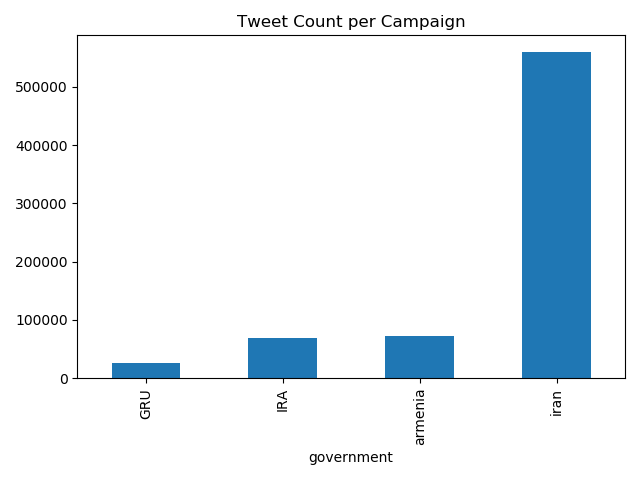

In [9]:
(tweets_df.groupby('government')
  .size()
).plot(kind='bar', title='Tweet Count per Campaign')
plt.tight_layout()

In [7]:
iran = tweets_df.loc[:][tweets_df['campaign'] =='iran202012']
iran_users = user_df.loc[:][user_df['campaign'] =='iran202012']

In [11]:
print('Total tweets: {}'.format(len(iran)))
print('Tweets per user:')
tweets_per_user = (iran
                .groupby('userid')
                .size()
                .describe()
                .astype('int')
)[['mean','std','min','max']]
print(tweets_per_user)
print('Tweets from max user: {:.2%}'
      .format(tweets_per_user.loc['max'] / len(iran)))

Total tweets: 560571
Tweets per user:
mean      2682
std      21022
min          1
max     302648
dtype: int64
Tweets from max user: 53.99%


In [12]:
print('Max user:')
max_user = (iran
           .groupby('userid')
           .size()
           .idxmax()
           )
max_user

Max user:


'213589457'

In [13]:
iran_users.loc[max_user]

user_display_name                                                    HispanTV
user_screen_name                                                     Hispantv
user_reported_location                                                Teherán
user_profile_description    Medio no corporativo, que se hace eco de las r...
user_profile_url                                       http://t.co/SU1GJqdDNM
follower_count                                                         161512
following_count                                                            31
account_creation_date                                     2010-11-09 00:00:00
account_language                                                           es
file                        hashed_2020_12_iran_202012_iran_202012_users_c...
campaign                                                           iran202012
release                                                                202012
government                                                      

In [14]:
print('Like counts per user:')
like_counts_per_user = (iran
                        .groupby('userid')
                        .sum()
                        .loc[:]['like_count']
                        .describe()
                        .astype('int')
                    )[['mean','std','min','max']]
like_counts_per_user

Like counts per user:


mean      13928
std      125374
min           0
max     1799708
Name: like_count, dtype: int64

In [15]:
most_liked_tweet = iran['like_count'].idxmax()
(iran
 .loc[most_liked_tweet]['tweet_text']
)

"I lived with Kavanaugh at Yale.The FBI never returned my call.\n\nMany were in the same place; they tried to get in contact with FBI, with no luck. Now GOP senators are claiming FBI report showed 'nothing they didn't already know'. Bullshit\nhttps://t.co/aIDK2IZ7ek \n\n#KavanaughLied"

In [16]:
(iran
 .loc[most_liked_tweet]
)

userid                           DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_display_name                DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_screen_name                 DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_reported_location                                             California
user_profile_description    "No one fixes the world alone."\n\n#BlueWave #...
user_profile_url                                                         <NA>
follower_count                                                           2439
following_count                                                          1164
account_creation_date                                     2019-08-18 00:00:00
account_language                                                           en
tweet_language                                                             en
tweet_text                  I lived with Kavanaugh at Yale.The FBI never r...
tweet_time                                                2019-0

In [17]:
most_liked_tweet_user = (iran
            .loc[most_liked_tweet]['userid']
            )
users.df.loc[most_liked_tweet_user][:-4]

user_display_name                DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_screen_name                 DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=
user_reported_location                                             California
user_profile_description    "No one fixes the world alone."\n\n#BlueWave #...
user_profile_url                                                         <NA>
follower_count                                                           2439
following_count                                                          1164
account_creation_date                                     2019-08-18 00:00:00
account_language                                                           en
Name: DFxoAH9UHHShlGfPqoJOBZroClD8H86DpwySU6YXl4E=, dtype: object

## Interactions

In [18]:
fields = ['follower_count',
             'following_count',
             'like_count',
             'quote_count',
             'reply_count',
             'retweet_count']

In [19]:
interactions = (iran
 .groupby('userid')
 .agg([np.mean,np.median])
 .loc[:][fields]
)

In [20]:
interactions

follower_count         \
                                                       mean median   
userid                                                               
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=              89     89   
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=              2      2   
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=            394    394   
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=            1694   1694   
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=             68     68   
...                                                     ...    ...   
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=             524    524   
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=             745    745   
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=                8      8   
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=               3      3   
zk4khaX7A3XhXVndteeiXLe4ma8xR7bYMBCOhCt68j8=              3      3   

                                             following_count         \
                                                        mean median   
userid                                                                
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=              267    267   
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=              27     27   
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=             751    751   
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=             5170   5170   
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=              57     57   
...                                                      ...    ...   
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=             1404   1404   
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=              794    794   
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=                46     46   
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=                5      5   
zk4khaX7A3XhXVndteeiXLe4ma8xR7bYMBCOhCt68j8=               0      0   

                                             like_count        quote_count  \
                                                   mean median        mean   
userid                                                                       
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=        0.73   0.00        0.01   
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=       0.11   0.00        0.01   
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=       1.79   0.50        0.05   
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=        3.10   1.00        0.19   
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=       0.03   0.00        0.00   
...                                                 ...    ...         ...   
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=        1.35   0.00        0.08   
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=        0.13   0.00        0.01   
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=         0.07   0.00        0.00   
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=        0.00   0.00        0.00   
zk4khaX7A3XhXVndteeiXLe4ma8xR7bYMBCOhCt68j8=       0.00   0.00        0.00   

                                                    reply_count         \
                                             median        mean median   
userid                                                                   
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=       0        0.09      0   
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=      0        0.14      0   
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=      0        0.34      0   
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=       0        0.17      0   
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=      0        0.03      0   
...                                             ...         ...    ...   
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=       0        0.18      0   
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=       0        0.23      0   
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=        0        0.05      0   
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=       0        0.00      0   
zk4khaX7A3XhXV

In [21]:
(iran
    .groupby('userid')
    .sum()
    .loc[:][fields]
    .describe()
    .astype('int')
).loc[['mean','std','min','max']]

,follower_count,following_count,like_count,quote_count,reply_count,retweet_count
mean,236431867,2291862,13928,644,1125,15008
std,3381026042,7693509,125374,7383,8918,192315
min,0,0,0,0,0,0
max,48881283776,74547444,1799708,106618,127521,2780592


In [22]:
(iran
 .loc[:][fields]
 .sort_values(by='like_count',ascending=False)
)

,follower_count,following_count,like_count,quote_count,reply_count,retweet_count
tweetid,,,,,,
1173315426039869441,2439,1164,63863,1155,1385,26269
1239483156408995842,2439,1164,18145,102,166,4503
1272051106609332230,254,136,12618,1109,504,9967
1251846530522324993,2439,1164,9124,297,444,4419
1257266574114934785,2439,1164,8311,124,423,1409
...,...,...,...,...,...,...
254446804874178560,161512,31,0,0,0,0
350759590369042432,161512,31,0,0,0,0
188572264176951296,161512,31,0,0,0,0


In [24]:
def mean_normalize(df):
    return (df - df.mean()) / df.std()

def min_max_normalize(df):
    return (df - df.min()) / (df.max() - df.min())

<IPython.core.display.Javascript object>


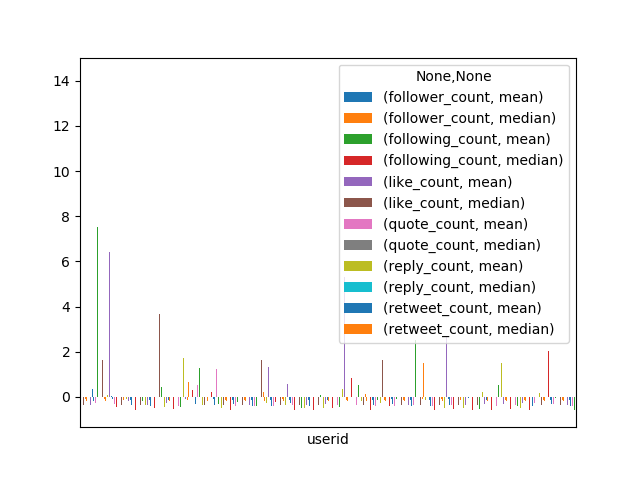

In [25]:
(interactions
 .pipe(mean_normalize)
 .plot(kind='bar', xticks=([]))
)

## Original Tweets vs. Retweets

In [ ]:
def original_tweets(tweets):
    is_retweet = tweets['is_retweet'] == 'False'
    return (tweets
            .loc[:][is_retweet]
           )

def retweets(tweets):
    is_retweet = tweets['is_retweet'] == 'True'
    return (tweets
            .loc[:][is_retweet]
           )

def replies(tweets):
    is_reply = tweets['in_reply_to_tweetid'].notna()
    return (tweets
            .loc[:][is_reply]
           )

## User connections

In [ ]:
# internal retweets: users in campaign retweeting tweets from users in campaign